In [165]:
import numpy as np  
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import os
from astropy.wcs import WCS
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry

In [166]:
def bias():
    path=os.getcwd()+'/bias'
    fitsfile=fits.open(path+'/'+'16-23-54_Ha_Bias_0.00s_0000.fits')
    datax = fitsfile[0].data

    Num_of_files=len(os.listdir(path))
    Grid=np.zeros(datax.shape)
    for file in os.listdir(path):
        fitsfile=fits.open(path+'/'+file)
        dati = fitsfile[0].data
        Grid+=dati
    Grid/=Num_of_files
    return Grid

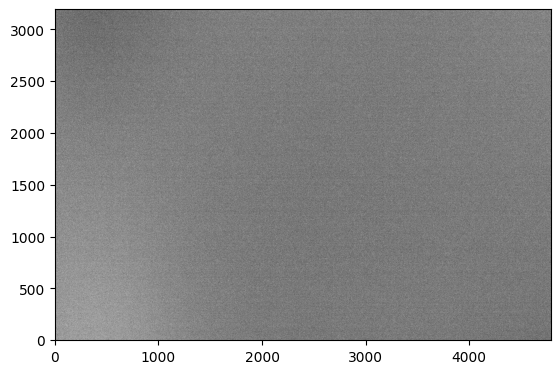

In [167]:
masterbias=bias()
mean=np.mean(masterbias)
std=np.std(masterbias)
plt.imshow(masterbias, cmap='gray', vmin=mean-2*std, vmax=mean+2*std, origin='lower')

In [168]:
pathf=os.getcwd()+'/RFLAT'
fitsfilef=fits.open(pathf+'/'+'2025-10-02_09-25-17_FLAT_R__0000.fits')
dataf = fitsfilef[0].data

In [169]:
def flat(filter):
    path=os.getcwd()+f"/{filter}FLAT"
    Num_of_files=len(os.listdir(path))
    Grid=np.zeros((dataf.shape[0],dataf.shape[1],Num_of_files))
    j=0
    for file in os.listdir(path):
        fitsfile=fits.open(path+'/'+file)
        dati = fitsfile[0].data
        Grid[:,:,j]=dati
        j+=1
    master=np.median(Grid, axis=2)-masterbias
    return master/np.median(master)

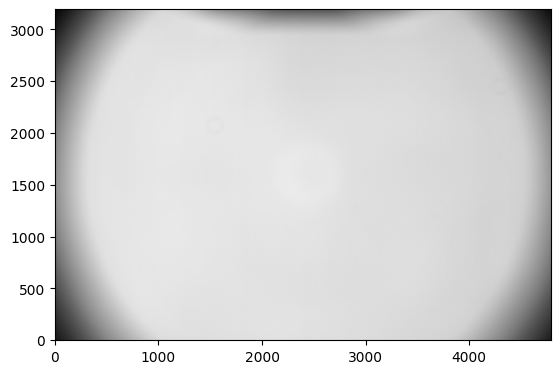

In [170]:
masterflat=flat('R')
plt.imshow(masterflat, cmap='gray', origin='lower')

In [171]:
pathd=os.getcwd()+'/DARK300'
fitsfiled=fits.open(pathd+'/'+'2025-09-25_17-59-33_DARK_300.00s_0000.fits')

datad = fitsfiled[0].data

In [172]:
def dark(time):
    path=os.getcwd()+'/DARK'+time
    Num_of_files=len(os.listdir(path))
    Grid=np.zeros((datad.shape[0],datad.shape[1],Num_of_files))
    j=0
    for file in os.listdir(path):
        fitsfile=fits.open(path+'/'+file)
        dati = fitsfile[0].data
        Grid[:,:,j]=dati
        j+=1
    master=np.median(Grid, axis=2)-masterbias
    return master

In [173]:
mastercurrent=dark('300')

In [174]:
fitsfiled=fits.open('2025-10-10_18-16-27_sci_M103_R_300.00s_0000.fits')
data = fitsfiled[0].data
wcs = WCS(fitsfiled[0].header)

Set MJD-AVG to 60958.763168 from DATE-AVG'. [astropy.wcs.wcs]


In [175]:
science= (data-masterbias-mastercurrent)/masterflat
mean_science=np.mean(science)
std_science=np.std(science)

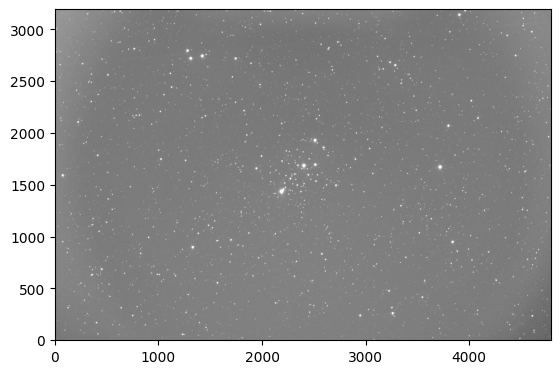

In [176]:
plt.imshow(science, vmin=mean_science-2*std_science, vmax=mean_science+2*std_science,cmap='gray',origin='lower')

In [177]:
GAIAspectrum = fits.open('GAIA3_509862066010920960.fits')

In [178]:
r_trasm = Table.read('r_trasmission.txt', format='ascii.basic')
g_trasm = Table.read('g_trasmission.txt', format='ascii.basic')
i_trasm = Table.read('i_trasmission.txt', format='ascii.basic')

r_wave=r_trasm["Wavelength(A)"]
r_value=r_trasm["Transmission(QE*Filter)"]
g_wave=g_trasm["Wavelength(A)"]
g_value=g_trasm["Transmission(QE*Filter)"]
i_wave=i_trasm["Wavelength(A)"]
i_value=i_trasm["Transmission(QE*Filter)"]

Text(0, 0.5, 'Flux (erg/cm$^2$/s/A)')

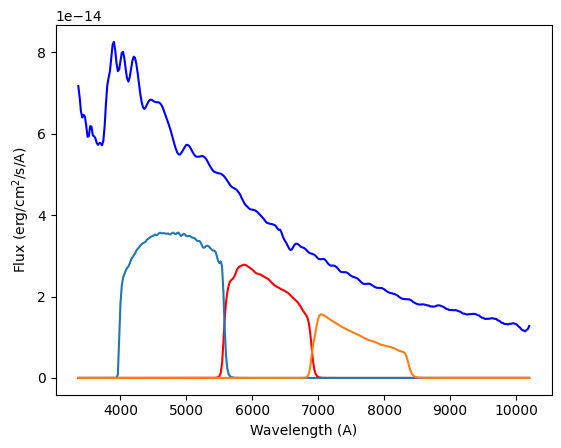

In [179]:
plt.plot(GAIAspectrum[1].data, GAIAspectrum[0].data, color='blue')

# new y of the filter 
#where we want to evaluate the interpolation, x and y 
r_trasm_new=np.interp(GAIAspectrum[1].data, r_wave, r_value)
g_trasm_new=np.interp(GAIAspectrum[1].data, g_wave, g_value)
i_trasm_new=np.interp(GAIAspectrum[1].data, i_wave, i_value)

plt.plot(GAIAspectrum[1].data, r_trasm_new*4*10**(-14),color='red')
#plt.plot(r_wave, r_value*4*10**(-14),color='red', linestyle='--')
plt.plot(GAIAspectrum[1].data, g_trasm_new*4*10**(-14))
plt.plot(GAIAspectrum[1].data, i_trasm_new*4*10**(-14))
plt.xlabel('Wavelength (A)')
plt.ylabel(r'Flux (erg/cm$^2$/s/A)')

In [180]:
x=GAIAspectrum[1].data
y_filter=r_trasm_new
y_spectrum=np.array(GAIAspectrum[0].data)

In [181]:
Num = np.trapz(y_spectrum * y_filter, x)
Den= np.trapz(y_filter, x)
F=Num/Den           # Factor for the flux
F

3.927128091939314e-14

In [182]:
pixpos = wcs.wcs_world2pix(23.38804096055661,60.63702187961969, 1)  # RA, DEC in degrees of the chosen 
pixpos      #pixel position of our star

[array(2450.43582191), array(1749.18995918)]

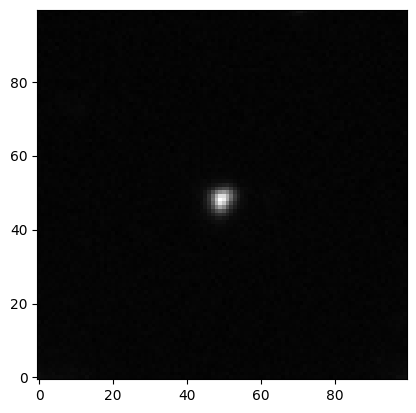

In [183]:
science_e=science*0.25/300         
sci_cut = science_e[1700:1800,2400:2500]
plt.imshow(sci_cut,cmap='gray',origin='lower') #it resclaes the pixel 

In [ ]:
position = pixpos[0]-2400, pixpos[1]-1700  # (x, y) position of the star in the cut_out
Apertures = [CircularAperture(position, r=i) for i in np.arange(1, 30, 0.5)]

In [206]:
fluxs=aperture_photometry(sci_cut,Apertures)
fluxs

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,aperture_sum_2,aperture_sum_3,aperture_sum_4,aperture_sum_5,aperture_sum_6,aperture_sum_7,aperture_sum_8,aperture_sum_9,aperture_sum_10,aperture_sum_11,aperture_sum_12,aperture_sum_13,aperture_sum_14,aperture_sum_15,aperture_sum_16,aperture_sum_17,aperture_sum_18,aperture_sum_19,aperture_sum_20,aperture_sum_21,aperture_sum_22,aperture_sum_23,aperture_sum_24,aperture_sum_25,aperture_sum_26,aperture_sum_27,aperture_sum_28,aperture_sum_29,aperture_sum_30,aperture_sum_31,aperture_sum_32,aperture_sum_33,aperture_sum_34,aperture_sum_35,aperture_sum_36,aperture_sum_37,aperture_sum_38,aperture_sum_39,aperture_sum_40,aperture_sum_41,aperture_sum_42,aperture_sum_43,aperture_sum_44,aperture_sum_45,aperture_sum_46,aperture_sum_47,aperture_sum_48,aperture_sum_49,aperture_sum_50,aperture_sum_51,aperture_sum_52,aperture_sum_53,aperture_sum_54,aperture_sum_55,aperture_sum_56,aperture_sum_57
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,50.43582191493215,49.18995917828329,73.17688588300365,159.0184486646687,269.1691821975233,396.26145855076453,536.8893495095513,683.7080716220675,838.425025991399,996.5819951222943,1162.6293158920105,1335.3341501444295,1518.2265327382931,1710.8138992074314,1915.2430454000673,2131.7167961008495,2361.631048839625,2604.9632873203655,2862.102504699288,3132.9591932254148,3417.66639198533,3716.3771089823376,4029.76725128041,4357.813758484176,4700.385559654624,5056.7765218198,5427.040846877238,5812.19516570833,6212.06040937199,6625.832762658264,7053.63990189853,7495.9062153448485,7952.447913191987,8422.983561772355,8908.066768197315,9408.215392296846,9922.90316876365,10451.869705022233,10995.67333861046,11553.957928779391,12126.716383620105,12713.58248180517,13314.619790293158,13930.073053167998,14559.878846673866,15204.68500009436,15863.75945007593,16537.368873584695,17226.067795831303,17928.1970024807,18644.49872330774,19375.103452477866,20119.80096396154,20879.52160299725,21654.30059641487,22442.869257746035,23245.225456989,24062.255679900634,24893.930124398827,25740.03665954731


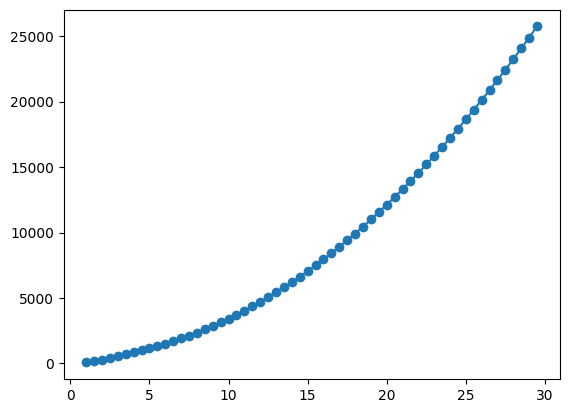

In [210]:
flux=fluxs[0][3:]
plt.plot(np.arange(1,30,0.5), flux, marker='o') #without background subtraction it increase as r^2

### Now we substract the background

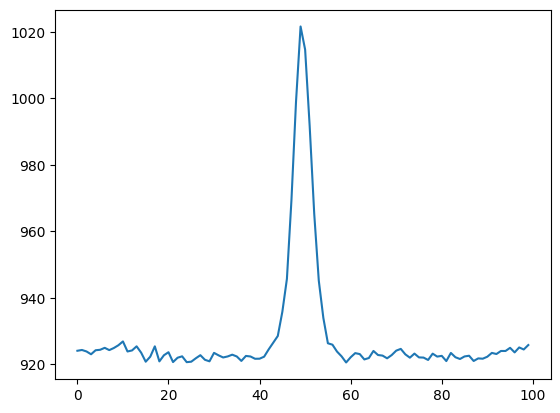

In [ ]:
star=np.sum(sci_cut, axis=0) #sum in a given direction 
plt.plot(star)

In [189]:
ri=20
rext=30
#where there the plot is flat 

In [207]:
annulus_aperture = CircularAnnulus(position, r_in=ri, r_out=rext)

In [191]:
from photutils.aperture import ApertureStats
aper_stats = ApertureStats(sci_cut, annulus_aperture)            #all the statistics
bkg_mean = aper_stats.mean
print(bkg_mean)

apertures_area = [A.area for A in Apertures]

9.213903262808001


In [ ]:
bkg_total=bkg_mean*np.array(apertures_area)

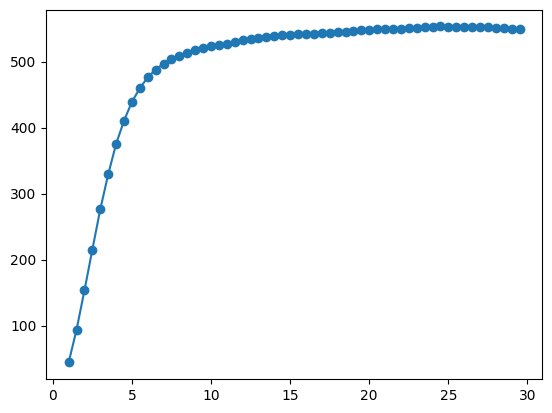

In [ ]:
phot_final= flux - bkg_total
plt.plot(np.arange(1,30,0.5), phot_final, marker='o')  #now it flattens at large r

(<matplotlib.patches.Circle at 0x132be6cc0>,)

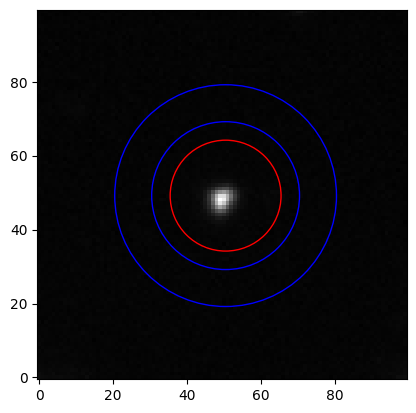

In [209]:
plt.imshow(sci_cut, cmap='gray', origin='lower')
annulus_aperture.plot(color='blue')

aperture = CircularAperture(position, r=15)
aperture.plot(color='red')

In [ ]:
r=15
ap=CircularAperture(position, r=15)
photo_inside=aperture_photometry(sci_cut,ap)
print(photo_inside)
final_flux=photo_inside[0][3:]

an_ap=CircularAnnulus(position, r_in=ri, r_out=rext)
aperstats= ApertureStats(sci_cut, an_ap)
bkg_mean=aperstats.mean
print(bkg_mean)

aperture_area=ap.area
total_bkg=bkg_mean*aperture_area
final_flux_bkgsubtracted=final_flux - total_bkg

 id      xcenter           ycenter        aperture_sum  
--- ----------------- ----------------- ----------------
  1 50.43582191493215 49.18995917828329 7053.63990189853
9.213903262808001


In [ ]:
F/final_flux_bkgsubtracted  #Calibraton Constant

array([7.26283655e-17])

## Lecture 5 - Sky sustraction: the proper way

In [ ]:
import sep

#the median can be influenced by very bright pixels and noisy edges 
data=science_e-np.median(science_e)
std=np.std(science_e)

#2 is the threshold in sigma
objects, map = sep.extract(data, 2, err=std, segmentation_map=True)              #return an image 
len(objects)

927

In [232]:
#size of the background pixels (64x64), size of the filter
#we want a smooth background, without small scale features 
bkg = sep.Background(data, mask=map, bw=64, bh=64, fw=12, fh=12)

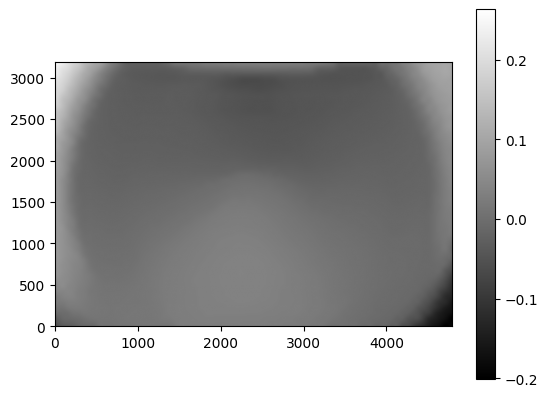

In [233]:
plt.imshow(bkg, cmap='gray', origin='lower')
plt.colorbar()

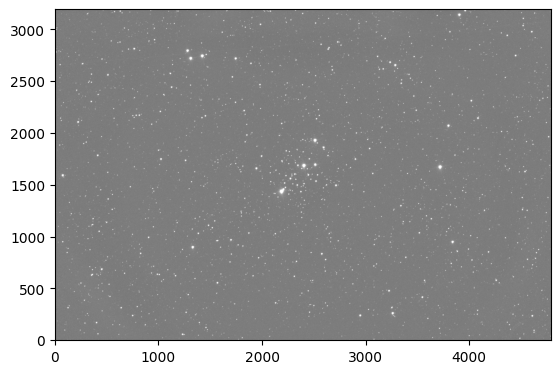

In [234]:
Final=science_e-bkg
mean_f=np.mean(Final)
std_f=np.std(Final)
plt.imshow(Final, vmin=mean_f-2*std_f,vmax=mean_f+2*std_f,cmap='gray', origin='lower')

### LECTURE 6


In [200]:
from reproject import reproject_interp

from astropy.coordinates import SkyCoord
from astropy import units as u


# coordinates of m103

c = SkyCoord('01:33:12 +60:42:00', unit=(u.hourangle, u.deg))
c

<SkyCoord (ICRS): (ra, dec) in deg
    (23.3, 60.7)>

In [238]:
ref_wcs =  WCS(naxis=2)

#metti le coordinate di M103
ref_wcs.wcs.crval =[c.ra.degree, c.dec.degree]
ref_wcs.wcs.crpix =[3500/2.0, 3500/2.0]  
ref_wcs.wcs.ctype =["RA---TAN", "DEC--TAN"] 
ref_wcs.wcs.cunit=["deg", "deg"]


#trasformation of 0.55 arcsec/pixel

dim_degrees= (0.55/3600.0)

#pixel orientation matrix
ref_wcs.wcs.cd= np.array([[-dim_degrees, 0.0], [0.0, dim_degrees]])

In [239]:
new_repr= reproject_interp((Final, wcs), ref_wcs, shape_out=(3500,3500))

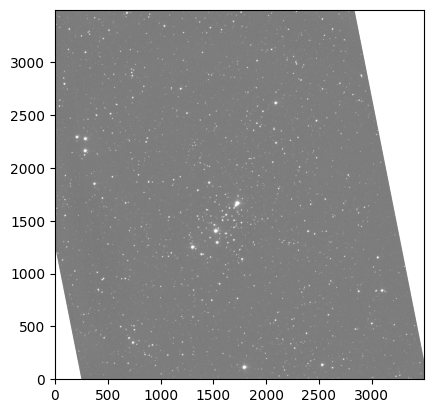

In [240]:
plt.imshow(new_repr[0], vmin=mean_f-2*std_f,vmax=mean_f+2*std_f,cmap='gray', origin='lower')